# MACS 30123: Final Project
# Improving Travel Time Calculations Between Schools in Peru
## Author: Andrei Bartra
### June 2021

## 1. Settings 
### 1.1 Modules

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Libraries

## Basic modules
import warnings
import pandas as pd
import numpy as np
import json
import urllib.request

#Geographic projections
#from pyproj import Proj, transform
#import geopandas as gpd

#Image processing modules
#import gdal
from skimage import graph

#Management 
import sys
import os
from pathlib import Path
import time
from functools import wraps

# Visualization
import matplotlib
import matplotlib.pyplot as plt

#Parallelization tools
from mpi4py import MPI

#Local Modules
#import astar


### 1.2 Globals

In [15]:

UGEL = '010001' #Test UGEL
SAMPLE_SIZE = 1000

### 1.3 Set up

In [6]:
PATH  = os.path.dirname(os.getcwd())
RASTER_UGEL = PATH + "\\data\\Time\\Por UGEL\\time_noclipgeo_UGEL_" + UGEL + ".tif"
warnings.filterwarnings('ignore')

## 2. Helper Functions

In [7]:

#Timer Decorator
# From https://stackoverflow.com/questions/3620943/measuring-elapsed-time-with-the-time-module 
PROF_DATA = {}

def profile(fn):
    @wraps(fn)
    def with_profiling(*args, **kwargs):
        start_time = time.time()

        ret = fn(*args, **kwargs)

        elapsed_time = time.time() - start_time

        if fn.__name__ not in PROF_DATA:
            PROF_DATA[fn.__name__] = [0, []]
        PROF_DATA[fn.__name__][0] += 1
        PROF_DATA[fn.__name__][1].append(elapsed_time)

        return ret

    return with_profiling


def print_prof_data():
    for fname, data in PROF_DATA.items():
        max_time = max(data[1])
        avg_time = sum(data[1]) / len(data[1])
        print ("Function %s called %d times. " % (fname, data[0]))
        print ('Execution time max: %.3f, average: %.3f' % (max_time, avg_time))


def clear_prof_data():
    global PROF_DATA
    PROF_DATA = {}


## 3. Data
### 3.1 Schools

In [8]:
sch =pd.read_stata(PATH + "\\data\\padronfinal201711.dta",
                   convert_categoricals=False,
                   columns = ['cod_mod', 'codlocal', 'codgeo', 'estrato', 'dominio', 'd_dpto', 'd_prov', 'd_dist', 
                              'd_region', 'codooii', 'nlat_ie', 'nlong_ie', 'estado', 'rural', 'matri2017' ])

sch = sch.loc[(sch.codlocal != '') &  # Has an edification
              (sch.rural.isin([1,2,3])) & # It is in a rural area
              (sch.estado == 1) & # it is active
              (sch.matri2017 > 0)] # has students

## Grouping by edification code
cols = sch.columns

sch = sch.groupby([c for c in cols if c not in ['cod_mod', 'estado', 'matri2017']], as_index=False)['matri2017'].sum()

## Cleaning UGEL codes
sch['codooii'] = sch['codooii'].astype(str).str.zfill(6)

## Transforming prjection to the raster projection

sch = gpd.GeoDataFrame(sch, geometry=gpd.points_from_xy(sch.nlong_ie, sch.nlat_ie))
sch.crs = {'init': 'epsg:4326'}
sch = sch.to_crs({'init': 'epsg:32718'})


,codlocal,codgeo,estrato,dominio,d_dpto,d_prov,d_dist,d_region,codooii,nlat_ie,nlong_ie,rural,matri2017,geometry
0,000043,010101,8.0,4.0,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,DRE AMAZONAS,010001,-6.24770,-77.88770,1.0,14.0,POINT (180434.088 9308537.062)
1,000081,020903,6.0,5.0,ANCASH,CORONGO,BAMBAS,DRE ANCASH,020009,-8.60320,-77.99360,3.0,17.0,POINT (170466.559 9047727.791)
2,000137,020904,8.0,5.0,ANCASH,CORONGO,CUSCA,DRE ANCASH,020009,-8.60240,-77.75223,2.0,25.0,POINT (197056.296 9048015.952)
3,000175,010101,8.0,4.0,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,DRE AMAZONAS,010001,-6.24680,-77.88810,1.0,24.0,POINT (180389.239 9308636.432)
4,000180,010101,8.0,4.0,AMAZONAS,CHACHAPOYAS,CHACHAPOYAS,DRE AMAZONAS,010001,-6.27490,-77.93930,2.0,8.0,POINT (174735.775 9305494.738)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41722,999445,050503,5.0,7.0,AYACUCHO,LA MAR,AYNA,DRE AYACUCHO,050005,-12.72270,-73.88460,2.0,140.0,POINT (621095.330 8593269.902)
41723,999515,220604,8.0,7.0,SAN MARTIN,MARISCAL CACERES,PACHIZA,DRE SAN MARTIN,220006,-7.28470,-76.93461,3.0,19.0,POINT (286412.919 9194320.984)
41724,999822,160511,7.0,7.0,LORETO,REQUENA,YAQUERANA,DRE LORETO,160001,-5.94350,-73.18785,3.0,43.0,POINT (700603.118 9342712.488)
41725,999879,120608,7.0,7.0,JUNIN,SATIPO,RIO TAMBO,DRE JUNIN,120012,-11.04088,-74.47006,3.0,73.0,POINT (557885.460 8779449.172)


In [26]:
len(sch.codooii.unique())

210

### 3.2 Raster Info

In [9]:
raster = gdal.Open(PATH + "\\data\\Time\\peru_tiempo_90m.tif")
array = raster.GetRasterBand(1).ReadAsArray()
array.shape


(21819, 15142)

#### Raster VIsualization
White spaces are non-navigable water bodies.

It is possible to navigate throught the Titicaca river in the south, however it is rarely used to go to school

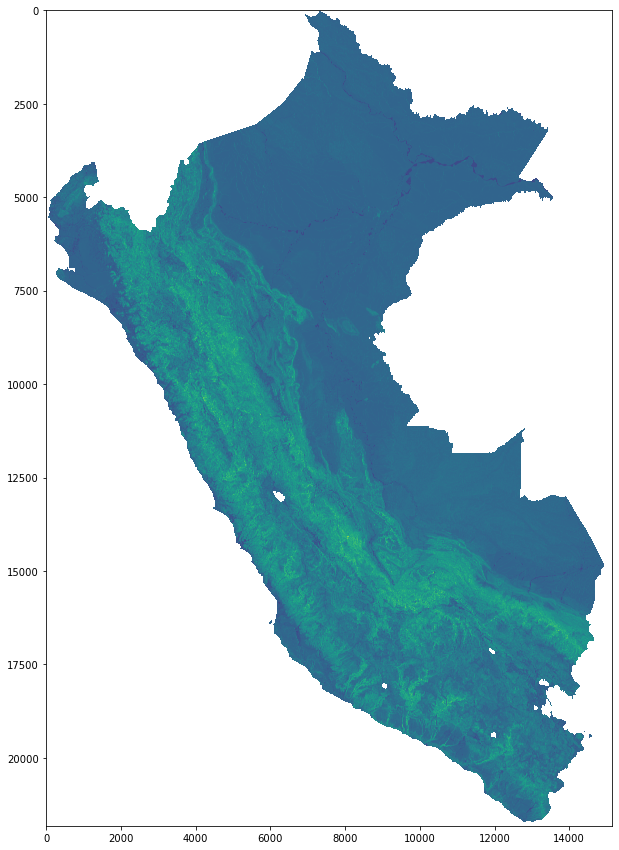

In [10]:
visual = array.copy()
visual[visual < 0] = np.nan
visual = np.log(visual)
visual[visual > 1] = 1

plt.figure(figsize=(15,15))
plt.imshow(visual) ## Improve image
visual = None

#### Georeferencing

In [11]:
array[array<0] = np.nan
array = array*30
geotransform = raster.GetGeoTransform()
originx = geotransform[0]
originy = geotransform[3]
pixelwidth = geotransform[1]
pixelheight = -1*geotransform[5]
geotransform

(-205619.1978554933,
 93.3335966471783,
 0.0,
 9995688.481493961,
 0.0,
 -93.33359664717834)

## 4. Sample Data
To test the application we are going to focus on one UGEL (Similar to a School Disctrict) in a rural area in Peru: Chachapoyas, Amazonas Department in the Middle north of the country. It is a good test area as it has jungle and mountains

Intense blue lines are roads

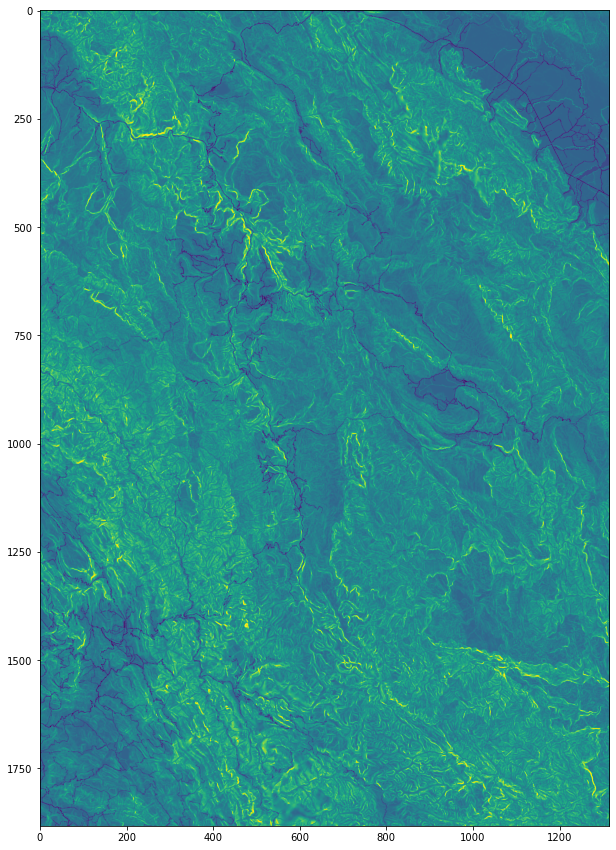

In [20]:
raster = gdal.Open(RASTER_UGEL)
array = raster.GetRasterBand(1).ReadAsArray()
visual = array.copy()
visual[visual < 0] = np.nan
visual = np.log(visual)
visual[visual > 1] = 1
plt.figure(figsize=(15,15))
plt.imshow(visual) ## Improve image

In [14]:
array[array<0] = np.nan
array = array*30
geotransform = raster.GetGeoTransform()
originx = geotransform[0]
originy = geotransform[3]
pixelwidth = geotransform[1]
pixelheight = -1*geotransform[5]
geotransform

(134021.76034358854,
 93.3335966471783,
 0.0,
 9372406.723084103,
 0.0,
 -93.33359664717844)

#### Sample Request:

I want to estimate all the travel times between rural schools in UGEL Chachapoyas


In [16]:
query = sch.loc[sch.codooii == UGEL, ['codlocal', 'codooii', 'geometry'] ]
print(type(query))
query['coord_x'] = query.geometry.x
query['coord_y'] = query.geometry.y

## Get array coordinates
query['pixel_x'] = ((query['coord_x'] - originx)/pixelwidth).astype(int)
query['pixel_y'] = ((originy - query['coord_y'])/pixelheight).astype(int)

## Sanity Check (removing points outside the range of the array)

query = query.loc[(query['pixel_x'] >= 0) &
                  (query['pixel_y'] >= 0) &
                  (query['pixel_x'] <= array.shape[0]) &
                  (query['pixel_y'] <= array.shape[1]),
                  ['codlocal', 'codooii' ,'pixel_x', 'pixel_y']]
query = query.merge(query, on='codooii')
query = query.loc[query.codlocal_x != query.codlocal_y]
#We only care for one way times
query['_codlocal_1'] = query['codlocal_x'].astype(int)
query['_codlocal_2'] = query['codlocal_y'].astype(int)
query['pair_index'] = query[['_codlocal_1', '_codlocal_2']].min(axis=1).astype(str) + "-" + query[['_codlocal_1', '_codlocal_2']].max(axis=1).astype(str)
query = query.drop_duplicates(subset=['pair_index'])
query = query.drop(['_codlocal_1', '_codlocal_2', 'pair_index'], axis=1)
query

<class 'geopandas.geodataframe.GeoDataFrame'>


,codlocal_x,codooii,pixel_x_x,pixel_y_x,codlocal_y,pixel_x_y,pixel_y_y
1,000043,010001,497,684,000175,496,683
2,000043,010001,497,684,000180,436,716
3,000043,010001,497,684,000199,562,691
4,000043,010001,497,684,000217,588,688
5,000043,010001,497,684,000222,576,689
...,...,...,...,...,...,...,...
16252,733813,010001,682,657,789664,732,462
16253,733813,010001,682,657,789678,623,609
16381,774549,010001,558,963,789664,732,462
16382,774549,010001,558,963,789678,623,609


## 4. Travel Time Function

The travel time function uses the route_through_array  from the sckit-image library array function that performs a weighted Djkstra algorithm under the hood


In [17]:
@profile
def travel_time(x_1, y_1, x_2, y_2, array, cost_only=True):
    route, cost = graph.route_through_array(array, (x_1, y_1), (x_2, y_2), geometric=True)
    if cost_only:
        return cost
    else:
        return route, cost


Visualizing one example

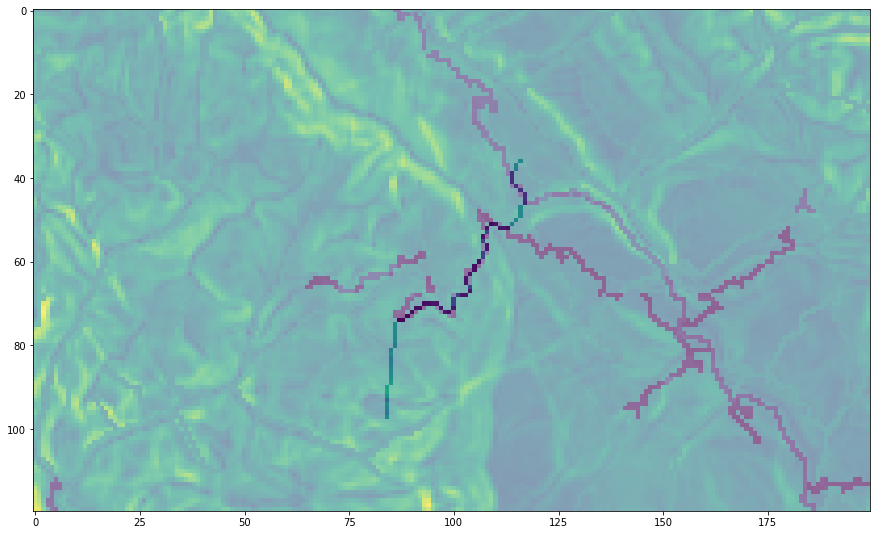

In [23]:
plt.close()
x_1, y_1, x_2, y_2 = 497, 684, 436, 716

route, cost = travel_time(x_1, y_1, x_2, y_2, array, cost_only=False)
route = np.array(route).T
path = np.full_like(array, 0)
path[route[0], route[1]] = 1

background = visual[400:520, 600:800]
path = path[400:520, 600:800]
plt.figure(figsize=(15,15))
plt.imshow(background)
cmap = matplotlib.cm.get_cmap('Reds', 200)
path = np.ma.masked_where(path == 1, path)


plt.imshow(path, cmap=cmap, alpha = 0.4)

plt.show()

In this example, the algorithm traverse roads for the most part. However, it has to traverse terrain where roads are not available. 

## 4. Local Sequential Version
For the next test we are going to focus on the forst 1,000 pairs. Keep in mind that this average sized UGEL generates 8,256 pairs. A usual travel-timne request entails several UGELs (up to 210) and in some cases the pairs should not be restricted by that.

Queries usually take weeks to complete.

In [27]:
@profile
def run_local(query, array):
    query['cost'] = query[['pixel_x_x', 'pixel_y_x', 'pixel_x_y', 'pixel_y_y']]. \
    apply(lambda x:  travel_time(x[0], x[1], x[2], x[3], array), axis=1)
    return query

query = run_local(query.iloc[0:SAMPLE_SIZE], array)

In [28]:
query

,codlocal_x,codooii,pixel_x_x,pixel_y_x,codlocal_y,pixel_x_y,pixel_y_y,cost
1,000043,010001,497,684,000175,496,683,0.041064
2,000043,010001,497,684,000180,436,716,1.366956
3,000043,010001,497,684,000199,562,691,2.401668
4,000043,010001,497,684,000217,588,688,1.867917
5,000043,010001,497,684,000222,576,689,1.991343
...,...,...,...,...,...,...,...,...
1031,000364,010001,656,345,789678,623,609,2.561137
1041,000401,010001,435,1262,000444,718,691,7.323866
1042,000401,010001,435,1262,000458,718,691,7.323866
1043,000401,010001,435,1262,000463,727,733,7.194342


This query in particular took:

In [29]:
PROF_DATA['run_local'][1][0]

459.50268959999084

## 5. Local Paralelization

### 5.1 MPI

In [30]:
to_mpi = query.drop('cost', axis=1)

to_mpi.to_csv('query.csv')
pd.DataFrame(array).to_csv("raster.csv")

files = {'query': 'query.csv', 
         'raster': 'raster.csv' }

with open('inputs.json', 'w') as fp:
    json.dump(files, fp)
    

I had to run in my WSL. Luckily my personal computer can take up to 12 threads

In [31]:
!mpirun -n 10 python3 ./mpi_code.py

'mpirun' is not recognized as an internal or external command,
operable program or batch file.


In [32]:
with open('mpi_times.json') as json_file:
    mpi_time =  json.load(json_file)
mpi_time['time']

129.9620442390442

## 6. Scaling up with AWS

Ideally I would configure a custom cluster to run MPI. Nonetheless, trying to do so it is very time consuming and frustrating. Luckily, the EMR cluster used in the Dask homework works!

Sadly the EC2 limit is 5 instances :(

aws emr create-cluster --name "Dask-Cluster" \
    --release-label emr-5.29.0 \
    --applications Name=Hadoop \
    --log-uri s3://aws-logs-macs-lsc-andrei-bartra/elasticmapreducer/ \
    --instance-type m5.xlarge \
    --instance-count 5 \
    --bootstrap-actions Path=s3://aws-emr-resources-macs-lsc-andrei-bartra/bootstrap-dask/bootstrap-dask,Args="[--conda-packages,bokeh,fastparquet,python-snappy,snappy,matplotlib,seaborn, mpi4py, scikit-image]" \
    --use-default-roles \
    --region us-east-1 \
    --ec2-attributes '{"KeyName":"macs_new"}'

The work flow is quite cumberstone so far:
- Upload the input files to an S3 bucket
- Load files into the EC2 instance (code below)
- Launch an EMR cluster and SSH with jupyter
- Run the next code to create a python file with the MPI code (second code chunk below)
- Run MPI

In [8]:
query = pd.read_csv('https://andreibartra-lsc-project.s3.amazonaws.com/query.csv')
query = query.drop(query.columns[0], axis=1)
raster = pd.read_csv('https://andreibartra-lsc-project.s3.amazonaws.com/raster.csv').to_numpy()
raster = raster[1:,1:]
with urllib.request.urlopen("https://andreibartra-lsc-project.s3.amazonaws.com/inputs.json") as url:
    inputs = json.loads(url.read().decode())



query.to_csv('query.csv')
pd.DataFrame(raster).to_csv("raster.csv")

files = {'query': 'query.csv', 
         'raster': 'raster.csv' }

with open('inputs.json', 'w') as fp:
    json.dump(files, fp)


In [9]:
%%writefile mpi_aws.py 

import numpy as np
import pandas as pd
import json
import os

#Local Parallelization
from mpi4py import MPI

#Time Duration Utilities
import time 
from functools import wraps

#Path Algorithm
from skimage import graph


#  ________________________________________
# |                                        |
# |            2: Time Decorator           |
# |________________________________________|

#Timer Decorator
# From https://stackoverflow.com/questions/3620943/measuring-elapsed-time-with-the-time-module 
PROF_DATA = {}

def profile(fn):
    @wraps(fn)
    def with_profiling(*args, **kwargs):
        start_time = time.time()

        ret = fn(*args, **kwargs)

        elapsed_time = time.time() - start_time

        if fn.__name__ not in PROF_DATA:
            PROF_DATA[fn.__name__] = [0, []]
        PROF_DATA[fn.__name__][0] += 1
        PROF_DATA[fn.__name__][1].append(elapsed_time)

        return ret

    return with_profiling


def print_prof_data():
    for fname, data in PROF_DATA.items():
        max_time = max(data[1])
        avg_time = sum(data[1]) / len(data[1])
        print ("Function %s called %d times. " % (fname, data[0]))
        print ('Execution time max: %.3f, average: %.3f' % (max_time, avg_time))


def clear_prof_data():
    global PROF_DATA
    PROF_DATA = {}


#  ________________________________________
# |                                        |
# |             3: Load Data               |
# |________________________________________|

def get_inputs(file):
    with open(file) as json_file:
        input_data =  json.load(json_file)
    return input_data


def loading_data(query_file, raster_file):
    query = pd.read_csv(query_file)
    query = query.drop(query.columns[0], axis=1)
    raster = np.genfromtxt(raster_file, delimiter=',')
    raster = raster[1:,1:]
    return query, raster


#  ________________________________________
# |                                        |
# |                 4: MPI                 |
# |________________________________________|


def travel_time(x_1, y_1, x_2, y_2, array, cost_only=True):
    route, cost = graph.route_through_array(array, (x_1, y_1), (x_2, y_2), geometric=True)
    if cost_only:
        return cost
    else:
        return route, cost


@profile
def run_mpi_local(query, array):
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    ini = int(rank*query.shape[0]/size)
    end = int((rank+1)*query.shape[0]/size)
    temp = query.iloc[ini:end]
    temp['cost'] = temp[['pixel_x_x', 'pixel_y_x', 'pixel_x_y', 'pixel_y_y']]. \
    apply(lambda x:  travel_time(x[0], x[1], x[2], x[3], array), axis=1)
    
    gather = None
    
    _list = comm.gather(temp,root=0)

    if rank ==0:
        gather = pd.concat(_list)

    return gather


def outputs(gather):
    if gather is not None:
        gather.to_csv('mpi_query.csv')
        exec_time = {'time': PROF_DATA['run_mpi_local'][1][0]}

        with open('mpi_times.json', 'w') as fp:
            json.dump(exec_time, fp)

#  ________________________________________
# |                                        |
# |        5: Compiling and Wrapping       |
# |________________________________________|

def mpi_wrapper():
    inputs = get_inputs('inputs.json')
    df, array = loading_data(inputs['query'], inputs['raster'])
    rv = run_mpi_local(df, array)
    outputs(rv)
def main():
    mpi_wrapper()

if __name__ == '__main__':
    main()

Writing mpi_aws.py


In [11]:
!mpirun -n 10 python3 mpi_aws.py 

mpi_aws.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apply(lambda x:  travel_time(x[0], x[1], x[2], x[3], array), axis=1)
mpi_aws.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apply(lambda x:  travel_time(x[0], x[1], x[2], x[3], array), axis=1)
mpi_aws.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [12]:
with open('mpi_times.json') as json_file:
        aws_times =  json.load(json_file)
aws_times

{'time': 244.09664034843445}

In [13]:
result = pd.read_csv("mpi_query.csv")
result

,Unnamed: 0,codlocal_x,codooii,pixel_x_x,pixel_y_x,codlocal_y,pixel_x_y,pixel_y_y,cost
0,0,43,10001,497,684,175,496,683,1.936846
1,1,43,10001,497,684,180,436,716,41.562278
2,2,43,10001,497,684,199,562,691,71.813601
3,3,43,10001,497,684,217,588,688,55.114353
4,4,43,10001,497,684,222,576,689,58.244273
...,...,...,...,...,...,...,...,...,...
995,995,364,10001,656,345,789678,623,609,78.645675
996,996,401,10001,435,1262,444,718,691,224.199128
997,997,401,10001,435,1262,458,718,691,224.199128
998,998,401,10001,435,1262,463,727,733,220.923207
